# Load CSV Fundamental Data into Zipline Custom Database

This notebook demonstrates how to:
1. Load fundamental data from CSV files
2. Map symbols to Zipline SIDs
3. Create a custom SQLite database
4. Use the data in Zipline Pipeline

This is a zipline-reloaded native approach (no QuantRocket dependencies).

## 1. Setup and Imports

In [2]:
import os
import glob
import sqlite3
import pandas as pd
import numpy as np
from pathlib import Path

# Zipline imports
from zipline.data.bundles import load as load_bundle, register
from zipline.data.bundles.sharadar_bundle import sharadar_bundle
from zipline.pipeline import Pipeline
from zipline.pipeline.data.db import Database, Column

# Register Sharadar bundle (in case extension.py didn't load)
try:
    # Try to register the bundle
    register(
        'sharadar',
        sharadar_bundle(
            tickers=None,
            incremental=True,
            include_funds=True,
        ),
    )
    print("✓ Registered Sharadar bundle")
except Exception as e:
    # Bundle may already be registered
    print(f"✓ Sharadar bundle already registered (or error: {e})")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 120)

print("✓ Imports complete")

✓ Registered Sharadar bundle
✓ Imports complete


## 2. Configuration

Set your database name and data directory paths.

In [4]:
# Configuration
DATABASE_NAME = "fundamentals"  # Name for your custom database
DATA_DIR = "/data/csv/"  # Directory with CSV files (persistent across Docker restarts)
VIX_SIGNAL_PATH = "/data/csv/vix_flag.csv"  # Optional VIX signal data
BC_DATA_PATH = "/data/csv/bc_data.csv"  # Optional BC signal data

# Database will be created in ZIPLINE_CUSTOM_DATA_DIR (from docker-compose.yml)
# This ensures the database is in the same location that the loader expects
DB_DIR = Path(os.environ.get('ZIPLINE_CUSTOM_DATA_DIR', '/data/custom_databases'))
DB_DIR.mkdir(parents=True, exist_ok=True)
DB_PATH = DB_DIR / f"{DATABASE_NAME}.sqlite"

# Database update mode:
# 'fresh' - Drop and recreate database (default)
# 'replace' - Insert or replace existing records (updates duplicates)
# 'ignore' - Insert or ignore (skips duplicates, keeps existing data)
UPDATE_MODE = 'fresh'  # Change to 'fresh', 'replace', or 'ignore'

print(f"Database will be created at: {DB_PATH}")
print(f"Update mode: {UPDATE_MODE}")
print(f"  - 'fresh': Drop and recreate database")
print(f"  - 'replace': Update existing records with new data")
print(f"  - 'ignore': Skip records that already exist")
print(f"\nLooking for CSV files in: {DATA_DIR}")
print(f"\n💡 Tip: Place your CSV files in /data/csv/ (inside container)")
print(f"   or ./data/csv/ (on host machine) for persistent storage")

Database will be created at: /data/custom_databases/fundamentals.sqlite
Update mode: fresh
  - 'fresh': Drop and recreate database
  - 'replace': Update existing records with new data
  - 'ignore': Skip records that already exist

Looking for CSV files in: /data/csv/

💡 Tip: Place your CSV files in /data/csv/ (inside container)
   or ./data/csv/ (on host machine) for persistent storage


## 3. Define Database Schema

Define the columns that will be in your custom database.

In [3]:
# Define your database schema
# This matches the columns from the QuantRocket example
SCHEMA = {
    'Symbol': 'TEXT',
    'Sid': 'INTEGER',
    'Date': 'TEXT',
    'RefPriceClose': 'REAL',
    'RefVolume': 'REAL',
    'CompanyCommonName': 'TEXT',
    'EnterpriseValue_DailyTimeSeries_': 'REAL',
    'CompanyMarketCap': 'REAL',
    'GICSSectorName': 'TEXT',
    'FOCFExDividends_Discrete': 'REAL',
    'InterestExpense_NetofCapitalizedInterest': 'REAL',
    'Debt_Total': 'REAL',
    'EarningsPerShare_Actual': 'REAL',
    'EarningsPerShare_SmartEstimate_prev_Q': 'REAL',
    'EarningsPerShare_ActualSurprise': 'REAL',
    'EarningsPerShare_SmartEstimate_current_Q': 'REAL',
    'LongTermGrowth_Mean': 'REAL',
    'PriceTarget_Median': 'REAL',
    'CombinedAlphaModelSectorRank': 'REAL',
    'CombinedAlphaModelSectorRankChange': 'REAL',
    'CombinedAlphaModelRegionRank': 'REAL',
    'TradeDate': 'TEXT',
    'EPS_SurpirsePrct_prev_Q': 'REAL',
    'Estpricegrowth_percent': 'REAL',
    'CashFlowComponent_Current': 'REAL',
    'EarningsQualityRegionRank_Current': 'REAL',
    'EnterpriseValueToEBIT_DailyTimeSeriesRatio_': 'REAL',
    'EnterpriseValueToEBITDA_DailyTimeSeriesRatio_': 'REAL',
    'EnterpriseValueToSales_DailyTimeSeriesRatio_': 'REAL',
    'Dividend_Per_Share_SmartEstimate': 'REAL',
    'CashFlowPerShare_BrokerEstimate': 'REAL',
    'FreeCashFlowPerShare_BrokerEstimate': 'REAL',
    'ForwardPEG_DailyTimeSeriesRatio_': 'REAL',
    'PriceEarningsToGrowthRatio_SmartEstimate_': 'REAL',
    'ReturnOnInvestedCapital_BrokerEstimate': 'REAL',
    'Recommendation_NumberOfTotal': 'REAL',
    'Recommendation_Median_1_5_': 'REAL',
    'Recommendation_NumberOfStrongBuy': 'REAL',
    'Recommendation_NumberOfBuy': 'REAL',
    'Recommendation_Mean_1_5_': 'REAL',
    'ReturnOnCapitalEmployed_Actual': 'REAL',
    'GrossProfitMargin_': 'REAL',
    'ReturnOnEquity_SmartEstimat': 'REAL',
    'ReturnOnAssets_SmartEstimate': 'REAL',
    'CashCashEquivalents_Total': 'REAL',
    'ForwardPriceToCashFlowPerShare_DailyTimeSeriesRatio_': 'REAL',
    'ForwardPriceToSalesPerShare_DailyTimeSeriesRatio_': 'REAL',
    'ForwardEnterpriseValueToOperatingCashFlow_DailyTimeSeriesRatio_': 'REAL',
    'GrossProfitMargin_ActualSurprise': 'REAL',
    'pred': 'REAL',  # VIX signal
    'bc1': 'REAL',  # BC signal
}



In [4]:
 # Find all CSV files
os.chdir(DATA_DIR)
csv_files = sorted(glob.glob('2009*.csv'))
csv_path = os.path.join(DATA_DIR, csv_files[0])

# Read CSV
df = pd.read_csv(csv_path)
print(f'Original columns: {list(df.columns[:10])}...')

print('Forward filling!')
# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# 1. Sort by Symbol then Date
df = df.sort_values(['Symbol', 'Date'])

# 2. Forward fill missing values PER SYMBOL
# Use apply with ffill to preserve all columns including Symbol
df = df.groupby('Symbol', group_keys=False).apply(lambda x: x.ffill())
print(f'Post ffil columns: {list(df.columns[:10])}...')
print("writing file back")

df.to_csv(csv_path, index=False)
print(f'Saved {len(df)} rows with columns: {list(df.columns[:5])}...')
df = None


Original columns: ['Date', 'Symbol', 'Instrument', 'RefPriceClose', 'RefVolume', 'CompanyCommonName', 'EnterpriseValue_DailyTimeSeries_', 'CompanyMarketCap', 'GICSSectorName', 'FOCFExDividends_Discrete']...
Forward filling!
Post ffil columns: ['Date', 'Symbol', 'Instrument', 'RefPriceClose', 'RefVolume', 'CompanyCommonName', 'EnterpriseValue_DailyTimeSeries_', 'CompanyMarketCap', 'GICSSectorName', 'FOCFExDividends_Discrete']...
writing file back
Saved 9010487 rows with columns: ['Date', 'Symbol', 'Instrument', 'RefPriceClose', 'RefVolume']...


## 4. Load CSV Files

Load all CSV files from the data directory and concatenate them.

In [5]:
# Find all CSV files
os.chdir(DATA_DIR)
csv_files = sorted(glob.glob('2009*.csv'))

print(f"Found {len(csv_files)} CSV files:")
for f in csv_files[:5]:  # Show first 5
    print(f"  - {f}")
if len(csv_files) > 5:
    print(f"  ... and {len(csv_files) - 5} more")

# Load and concatenate all CSV files IN CHUNKS to save memory
print("\nLoading CSV files in chunks (memory-efficient mode)...")

# First pass: just get column info and count rows
csv_path = os.path.join(DATA_DIR, csv_files[0])
sample = pd.read_csv(csv_path, nrows=5)
print(f"Columns in CSV: {len(sample.columns)}")
print(f"Columns in CSV: {sample.columns}")


# Count total rows
total_rows = sum(1 for _ in open(csv_path)) - 1  # minus header
print(f"Total rows in CSV: {total_rows:,}")

# We'll process in chunks later - for now just load a sample to show structure
custom_data = pd.read_csv(csv_path, nrows=1000)
custom_data.drop(columns=['BSid','Instrument','pred'], inplace=True, errors='ignore')

print(f"\n✓ Loaded sample of 1,000 rows for preview")
print(f"Full dataset has {total_rows:,} rows - will be processed in chunks")
print(f"Date range (sample): {custom_data['Date'].min()} to {custom_data['Date'].max()}")
print(f"Unique symbols (sample): {custom_data['Symbol'].nunique()}")

# Store path for chunk processing later
CSV_PATH_FOR_CHUNKS = csv_path
CHUNK_SIZE = 600000  # Process 200k rows at a time

print("\nSample data:")
custom_data.head()

Found 1 CSV files:
  - 20091231_20251118.csv

Loading CSV files in chunks (memory-efficient mode)...
Columns in CSV: 38
Columns in CSV: Index(['Date', 'Symbol', 'Instrument', 'RefPriceClose', 'RefVolume', 'CompanyCommonName',
       'EnterpriseValue_DailyTimeSeries_', 'CompanyMarketCap', 'GICSSectorName', 'FOCFExDividends_Discrete',
       'InterestExpense_NetofCapitalizedInterest', 'Debt_Total', 'EarningsPerShare_Actual',
       'EarningsPerShare_SmartEstimate_prev_Q', 'EarningsPerShare_ActualSurprise',
       'EarningsPerShare_SmartEstimate_current_Q', 'LongTermGrowth_Mean', 'PriceTarget_Median',
       'CombinedAlphaModelSectorRank', 'CombinedAlphaModelSectorRankChange', 'CombinedAlphaModelRegionRank',
       'EarningsQualityRegionRank_Current', 'EnterpriseValueToEBIT_DailyTimeSeriesRatio_',
       'EnterpriseValueToEBITDA_DailyTimeSeriesRatio_', 'EnterpriseValueToSales_DailyTimeSeriesRatio_',
       'Dividend_Per_Share_SmartEstimate', 'CashCashEquivalents_Total', 'ForwardPEG_DailyT

,Date,Symbol,RefPriceClose,RefVolume,CompanyCommonName,EnterpriseValue_DailyTimeSeries_,CompanyMarketCap,GICSSectorName,FOCFExDividends_Discrete,InterestExpense_NetofCapitalizedInterest,Debt_Total,EarningsPerShare_Actual,EarningsPerShare_SmartEstimate_prev_Q,EarningsPerShare_ActualSurprise,EarningsPerShare_SmartEstimate_current_Q,LongTermGrowth_Mean,PriceTarget_Median,CombinedAlphaModelSectorRank,CombinedAlphaModelSectorRankChange,CombinedAlphaModelRegionRank,EarningsQualityRegionRank_Current,EnterpriseValueToEBIT_DailyTimeSeriesRatio_,EnterpriseValueToEBITDA_DailyTimeSeriesRatio_,EnterpriseValueToSales_DailyTimeSeriesRatio_,Dividend_Per_Share_SmartEstimate,CashCashEquivalents_Total,ForwardPEG_DailyTimeSeriesRatio_,PriceEarningsToGrowthRatio_SmartEstimate_,Recommendation_Median_1_5_,ReturnOnEquity_SmartEstimat,ReturnOnAssets_SmartEstimate,ForwardPriceToCashFlowPerShare_DailyTimeSeriesRatio_,ForwardPriceToSalesPerShare_DailyTimeSeriesRatio_,ForwardEnterpriseValueToOperatingCashFlow_DailyTimeSeriesRatio_,GrossProfitMargin_ActualSurprise,Estpricegrowth_percent,TradeDate
0,2009-12-31,A,22.217753,NaN,Agilent Technologies Inc,1.125719e+10,1.083819e+10,Health Care,183000000.0,21000000.0,2.904000e+09,0.32,NaN,37.404,NaN,15.0,33.0,40.0,NaN,41.0,40.0,32.535225,22.335690,2.512204,NaN,2.479000e+09,0.993966,NaN,2.0,NaN,NaN,13.785078,1.609831,20.022743,4.081,0.485299,2009-12-31
1,2010-01-04,A,22.382223,894600.0,Agilent Technologies Inc,1.133742e+10,1.091842e+10,Health Care,183000000.0,21000000.0,2.904000e+09,0.32,NaN,37.404,NaN,15.0,33.0,44.0,2.0,43.0,40.0,32.767107,22.494879,2.530109,NaN,2.479000e+09,0.999386,NaN,2.0,NaN,NaN,13.857960,1.620728,20.123099,4.081,0.474384,2010-01-04
2,2010-01-05,A,22.139094,828100.0,Agilent Technologies Inc,1.121882e+10,1.079982e+10,Health Care,183000000.0,21000000.0,2.904000e+09,0.32,NaN,37.404,NaN,15.0,33.0,42.0,-1.0,41.0,40.0,32.424325,22.259556,2.503641,NaN,2.479000e+09,0.988052,NaN,2.0,NaN,NaN,13.700236,1.602871,19.902142,4.081,0.490576,2010-01-05
3,2010-01-06,A,22.060434,852400.0,Agilent Technologies Inc,1.118232e+10,1.076332e+10,Health Care,183000000.0,21000000.0,2.904000e+09,0.32,NaN,37.404,NaN,15.0,33.0,43.0,2.0,42.0,40.0,32.318846,22.187144,2.495497,NaN,2.479000e+09,0.984066,NaN,2.0,NaN,NaN,13.644399,1.597203,19.823539,4.081,0.495891,2010-01-06
4,2010-01-07,A,22.031830,603700.0,Agilent Technologies Inc,1.116837e+10,1.074937e+10,Health Care,183000000.0,21000000.0,2.904000e+09,0.32,NaN,37.404,NaN,15.0,33.0,41.0,-1.0,40.0,40.0,32.278512,22.159454,2.492382,NaN,2.479000e+09,0.982315,NaN,2.0,NaN,NaN,13.619564,1.594881,19.788420,4.081,0.497833,2010-01-07


,Date,Symbol,Instrument,RefPriceClose,RefVolume,CompanyCommonName,EnterpriseValue_DailyTimeSeries_,CompanyMarketCap,GICSSectorName,FOCFExDividends_Discrete,InterestExpense_NetofCapitalizedInterest,Debt_Total,EarningsPerShare_Actual,EarningsPerShare_SmartEstimate_prev_Q,EarningsPerShare_ActualSurprise,EarningsPerShare_SmartEstimate_current_Q,LongTermGrowth_Mean,PriceTarget_Median,CombinedAlphaModelSectorRank,CombinedAlphaModelSectorRankChange,CombinedAlphaModelRegionRank,EarningsQualityRegionRank_Current,EnterpriseValueToEBIT_DailyTimeSeriesRatio_,EnterpriseValueToEBITDA_DailyTimeSeriesRatio_,EnterpriseValueToSales_DailyTimeSeriesRatio_,Dividend_Per_Share_SmartEstimate,CashCashEquivalents_Total,ForwardPEG_DailyTimeSeriesRatio_,PriceEarningsToGrowthRatio_SmartEstimate_,Recommendation_Median_1_5_,ReturnOnEquity_SmartEstimat,ReturnOnAssets_SmartEstimate,ForwardPriceToCashFlowPerShare_DailyTimeSeriesRatio_,ForwardPriceToSalesPerShare_DailyTimeSeriesRatio_,ForwardEnterpriseValueToOperatingCashFlow_DailyTimeSeriesRatio_,GrossProfitMargin_ActualSurprise,Estpricegrowth_percent,TradeDate
0,2009-12-31,A,A.N,22.217753,NaN,Agilent Technologies Inc,1.125719e+10,1.083819e+10,Health Care,183000000.0,21000000.0,2.904000e+09,0.32,NaN,37.404,NaN,15.0,33.0,40.0,NaN,41.0,40.0,32.535225,22.335690,2.512204,NaN,2.479000e+09,0.993966,NaN,2.0,NaN,NaN,13.785078,1.609831,20.022743,4.081,0.485299,2009-12-31
1,2010-01-04,A,A.N,22.382223,894600.0,Agilent Technologies Inc,1.133742e+10,1.091842e+10,Health Care,183000000.0,21000000.0,2.904000e+09,0.32,NaN,37.404,NaN,15.0,33.0,44.0,2.0,43.0,40.0,32.767107,22.494879,2.530109,NaN,2.479000e+09,0.999386,NaN,2.0,NaN,NaN,13.857960,1.620728,20.123099,4.081,0.474384,2010-01-04
2,2010-01-05,A,A.N,22.139094,828100.0,Agilent Technologies Inc,1.121882e+10,1.079982e+10,Health Care,183000000.0,21000000.0,2.904000e+09,0.32,NaN,37.404,NaN,15.0,33.0,42.0,-1.0,41.0,40.0,32.424325,22.259556,2.503641,NaN,2.479000e+09,0.988052,NaN,2.0,NaN,NaN,13.700236,1.602871,19.902142,4.081,0.490576,2010-01-05
3,2010-01-06,A,A.N,22.060434,852400.0,Agilent Technologies Inc,1.118232e+10,1.076332e+10,Health Care,183000000.0,21000000.0,2.904000e+09,0.32,NaN,37.404,NaN,15.0,33.0,43.0,2.0,42.0,40.0,32.318846,22.187144,2.495497,NaN,2.479000e+09,0.984066,NaN,2.0,NaN,NaN,13.644399,1.597203,19.823539,4.081,0.495891,2010-01-06
4,2010-01-07,A,A.N,22.031830,603700.0,Agilent Technologies Inc,1.116837e+10,1.074937e+10,Health Care,183000000.0,21000000.0,2.904000e+09,0.32,NaN,37.404,NaN,15.0,33.0,41.0,-1.0,40.0,40.0,32.278512,22.159454,2.492382,NaN,2.479000e+09,0.982315,NaN,2.0,NaN,NaN,13.619564,1.594881,19.788420,4.081,0.497833,2010-01-07


## 5. Optional: Load Recent Data Only

To reduce memory usage, you can filter to recent data only.

In [7]:
# Optional: Keep only recent data (e.g., last 600,000 rows)
# Comment out if you want all historical data
# RECENT_ROWS = 600000

# if len(custom_data) > RECENT_ROWS:
#     print(f"Filtering to most recent {RECENT_ROWS:,} rows...")
#     custom_data = custom_data.tail(RECENT_ROWS).copy()
#     print(f"✓ Filtered. New date range: {custom_data['Date'].min()} to {custom_data['Date'].max()}")
# else:
#     print(f"Dataset has {len(custom_data):,} rows - no filtering needed")

## 6. Map Symbols to Zipline SIDs (WITH TEMPORAL MAPPING)

Map your symbols to Zipline Security IDs (SIDs) using **temporal lookups** to handle symbol changes.

**IMPORTANT UPDATE**: This notebook now uses **temporal SID mapping** which correctly handles:
- Company name changes (FB → META, etc.)
- Ticker symbol changes over time
- Mergers and acquisitions

The temporal mapper uses `asset_finder.lookup_symbol(symbol, as_of_date)` to get the correct SID for each row's date, ensuring continuous data for companies that changed symbols.

**How it works:**
- For a row with Symbol='FB', Date='2020-01-01' → Returns META's SID (the company)
- For a row with Symbol='META', Date='2023-01-01' → Returns same META SID
- Result: Continuous data under one SID, no breaks at symbol changes

In [7]:
# =============================================================================
# MEMORY-EFFICIENT CHUNK PROCESSING
# =============================================================================
# This cell processes the entire CSV in chunks, maps SIDs, merges signals,
# and writes directly to the database without loading everything into memory.

import sys
sys.path.insert(0, '/app/examples/shared_modules')

from zipline.data.bundles import load as load_bundle
from temporal_sid_mapper import TemporalSIDMapper
import time

print("="*80)
print("MEMORY-EFFICIENT CHUNK PROCESSING")
print("="*80)

# Step 1: Load asset finder
print("\n1. Loading Sharadar bundle...")
bundle_timestamp = pd.Timestamp.now(tz='UTC')
bundle_data = load_bundle('sharadar', timestamp=bundle_timestamp)
asset_finder = bundle_data.asset_finder
print(f"   Asset finder loaded with {len(asset_finder.sids):,} securities")

# Step 2: Load signal data (small files - safe to load fully)
print("\n2. Loading signal data...")
vix_signal = None
bc_signal = None

if os.path.exists(VIX_SIGNAL_PATH):
    vix_signal = pd.read_csv(VIX_SIGNAL_PATH)
    print(vix_signal.tail())
    
    vix_signal.rename(columns={'symbol': 'Symbol', 'date': 'Date'}, inplace=True)
    # Use format='mixed' to handle various date formats (e.g., 6/15/09 or 2009-06-15)
    vix_signal['Date'] = pd.to_datetime(vix_signal['Date'], format='mixed').dt.strftime('%Y-%m-%d')
    print(vix_signal.tail())
    print(JJ)
    print(f"   VIX signal: {len(vix_signal)} rows")
else:
    print(f"   VIX signal not found at {VIX_SIGNAL_PATH}")

if os.path.exists(BC_DATA_PATH):
    bc_signal = pd.read_csv(BC_DATA_PATH)
    bc_signal.rename(columns={'symbol': 'Symbol', 'date': 'Date'}, inplace=True)
    # Use format='mixed' to handle various date formats
    bc_signal['Date'] = pd.to_datetime(bc_signal['Date'], format='mixed').dt.strftime('%Y-%m-%d')
    print(f"   BC signal: {len(bc_signal)} rows")
else:
    print(f"   BC signal not found at {BC_DATA_PATH}")

# Step 3: Prepare database
print("\n3. Preparing database...")

if UPDATE_MODE == 'fresh' and DB_PATH.exists():
    print(f"   Removing existing database (mode='fresh')...")
    DB_PATH.unlink()

conn = sqlite3.connect(str(DB_PATH))
cursor = conn.cursor()

# Step 4: Process CSV in chunks
# First, count total rows for progress tracking
print(f"\n4. Processing CSV in chunks of {CHUNK_SIZE:,} rows...")
total_csv_rows = sum(1 for _ in open(CSV_PATH_FOR_CHUNKS)) - 1  # minus header
total_chunks = (total_csv_rows + CHUNK_SIZE - 1) // CHUNK_SIZE
print(f"   Total rows in CSV: {total_csv_rows:,}")
print(f"   Expected chunks: {total_chunks}")
print("")

# Build symbol lookup cache
symbol_to_sid = {}
table_created = False
total_rows = 0
total_mapped = 0
unmapped_symbols = set()
start_time = time.time()

for chunk_num, chunk in enumerate(pd.read_csv(CSV_PATH_FOR_CHUNKS, chunksize=CHUNK_SIZE)):
    chunk_start = time.time()
    
    # Drop unwanted columns
    cols_to_drop = [c for c in ['BSid', 'Instrument', 'pred'] if c in chunk.columns]
    if cols_to_drop:
        chunk = chunk.drop(columns=cols_to_drop)
    
    # Convert date - use mixed format to handle various date formats
    chunk['Date'] = pd.to_datetime(chunk['Date'], format='mixed')
    
    # Map symbols to SIDs (batch lookup for efficiency)
    unique_symbols = chunk['Symbol'].unique()
    for sym in unique_symbols:
        if sym not in symbol_to_sid:
            try:
                asset = asset_finder.lookup_symbol(sym, as_of_date=None)
                if asset:
                    symbol_to_sid[sym] = int(asset.sid)
            except:
                pass
    
    # Apply SID mapping
    chunk['Sid'] = chunk['Symbol'].map(symbol_to_sid)
    
    # Track unmapped
    unmapped = chunk[chunk['Sid'].isna()]['Symbol'].unique()
    unmapped_symbols.update(unmapped)
    
    # Remove unmapped rows
    chunk = chunk[chunk['Sid'].notna()].copy()
    if len(chunk) == 0:
        continue
    chunk['Sid'] = chunk['Sid'].astype(int)
    
    # Merge VIX signal
    if vix_signal is not None:
        chunk['Date_str'] = chunk['Date'].dt.strftime('%Y-%m-%d')
        chunk = chunk.merge(
            vix_signal[['Symbol', 'Date', 'pred']], 
            left_on=['Symbol', 'Date_str'],
            right_on=['Symbol', 'Date'],
            how='left',
            suffixes=('', '_vix')
        )
        chunk = chunk.drop(columns=['Date_vix', 'Date_str'], errors='ignore')
    else:
        chunk['pred'] = np.nan
    
    # Merge BC signal
    if bc_signal is not None:
        chunk['Date_str'] = chunk['Date'].dt.strftime('%Y-%m-%d')
        chunk = chunk.merge(
            bc_signal[['Symbol', 'Date', 'bc1']], 
            left_on=['Symbol', 'Date_str'],
            right_on=['Symbol', 'Date'],
            how='left',
            suffixes=('', '_bc')
        )
        chunk = chunk.drop(columns=['Date_bc', 'Date_str'], errors='ignore')
    else:
        chunk['bc1'] = np.nan
    
    # Forward fill missing values by symbol
    for col in chunk.columns:
        if col not in ['Symbol', 'Sid', 'Date']:
            chunk[col] = chunk.groupby('Symbol')[col].transform(lambda x: x.ffill())
    
    # Fill remaining NaNs
    for col in chunk.columns:
        if col not in ['Symbol', 'Sid', 'Date']:
            if chunk[col].dtype == 'object' or col in ['GICSSectorName', 'CompanyCommonName', 'TradeDate']:
                chunk[col] = chunk[col].fillna('')
            else:
                chunk[col] = chunk[col].fillna(0)
    
    # Convert date to string for SQLite
    chunk['Date'] = chunk['Date'].dt.strftime('%Y-%m-%d')
    
    # Deduplicate
    chunk = chunk.drop_duplicates(subset=['Sid', 'Date'], keep='last')
    
    # Create table on first chunk
    if not table_created:
        cursor.execute("DROP TABLE IF EXISTS Price")
        
        # Build schema from chunk columns
        columns = []
        for col in chunk.columns:
            if col == 'Sid':
                columns.append(f'"{col}" INTEGER')
            elif col in ['Date', 'Symbol', 'CompanyCommonName', 'GICSSectorName', 'TradeDate']:
                columns.append(f'"{col}" TEXT')
            else:
                columns.append(f'"{col}" REAL')
        
        create_sql = f'''
            CREATE TABLE Price (
                {', '.join(columns)},
                UNIQUE(Sid, Date)
            )
        '''
        cursor.execute(create_sql)
        cursor.execute('CREATE INDEX IF NOT EXISTS idx_sid ON Price(Sid)')
        cursor.execute('CREATE INDEX IF NOT EXISTS idx_date ON Price(Date)')
        cursor.execute('CREATE INDEX IF NOT EXISTS idx_symbol ON Price(Symbol)')
        conn.commit()
        table_created = True
        print(f"   Table created with {len(columns)} columns\n")
    
    # Insert data
    placeholders = ', '.join(['?' for _ in chunk.columns])
    column_names = ', '.join([f'"{c}"' for c in chunk.columns])
    
    if UPDATE_MODE == 'replace':
        insert_sql = f'INSERT OR REPLACE INTO Price ({column_names}) VALUES ({placeholders})'
    elif UPDATE_MODE == 'ignore':
        insert_sql = f'INSERT OR IGNORE INTO Price ({column_names}) VALUES ({placeholders})'
    else:
        insert_sql = f'INSERT OR REPLACE INTO Price ({column_names}) VALUES ({placeholders})'
    
    cursor.executemany(insert_sql, chunk.values.tolist())
    conn.commit()
    
    total_mapped += len(chunk)
    total_rows += len(chunk)
    
    # Progress update
    chunk_time = time.time() - chunk_start
    elapsed = time.time() - start_time
    progress = (chunk_num + 1) / total_chunks * 100
    rows_per_sec = total_rows / elapsed if elapsed > 0 else 0
    eta_seconds = (total_csv_rows - (chunk_num + 1) * CHUNK_SIZE) / rows_per_sec if rows_per_sec > 0 else 0
    eta_min = eta_seconds / 60
    
    print(f"   Chunk {chunk_num + 1}/{total_chunks} ({progress:.1f}%) | "
          f"{total_mapped:,} rows | "
          f"{rows_per_sec:,.0f} rows/sec | "
          f"ETA: {eta_min:.1f} min")

# Final stats
cursor.execute("SELECT COUNT(*) FROM Price")
db_rows = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM Price WHERE pred IS NOT NULL AND pred != 0")
pred_rows = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM Price WHERE bc1 IS NOT NULL AND bc1 != 0")
bc1_rows = cursor.fetchone()[0]

conn.close()

total_time = time.time() - start_time

print("\n" + "="*80)
print("PROCESSING COMPLETE")
print("="*80)
print(f"Database: {DB_PATH}")
print(f"Total rows in database: {db_rows:,}")
print(f"Rows with VIX signal (pred): {pred_rows:,}")
print(f"Rows with BC signal (bc1): {bc1_rows:,}")
print(f"Unmapped symbols: {len(unmapped_symbols)}")
if len(unmapped_symbols) > 0:
    print(f"  First 10 unmapped: {list(unmapped_symbols)[:10]}")
print(f"File size: {DB_PATH.stat().st_size / (1024**3):.2f} GB")
print(f"Total time: {total_time/60:.1f} minutes ({total_time:.0f} seconds)")
print(f"Average speed: {db_rows/total_time:,.0f} rows/second")
print("="*80)

MEMORY-EFFICIENT CHUNK PROCESSING

1. Loading Sharadar bundle...
   Asset finder loaded with 30,775 securities

2. Loading signal data...
          date symbol  pred
4653  11/15/25    IBM     0
4654  11/16/25    IBM     0
4655  11/17/25    IBM     0
4656  11/18/25    IBM     0
4657  11/19/25    IBM     0
            Date Symbol  pred
4653  2025-11-15    IBM     0
4654  2025-11-16    IBM     0
4655  2025-11-17    IBM     0
4656  2025-11-18    IBM     0
4657  2025-11-19    IBM     0


NameError: name 'JJ' is not defined

## 7. Data Loading Complete

Cell 14 above handles all processing:
- Loads CSV in memory-efficient chunks
- Maps symbols to SIDs
- Merges VIX/BC signal data
- Deduplicates data
- Creates SQLite database at `/data/custom_databases/fundamentals.sqlite`

No additional processing steps needed.

## 8. Define Database Class

Create a Database class to use this data in Zipline Pipeline.

In [9]:
# Define the Database class
class CustomFundamentals(Database):
    """
    Custom Custom fundamentals database.
    
    Usage in Pipeline:
        roe = CustomFundamentals.ReturnOnEquity_SmartEstimat.latest
        sector = CustomFundamentals.GICSSectorName.latest
    """
    
    CODE = DATABASE_NAME
    LOOKBACK_WINDOW = 252  # Days to look back
    
    # Price and volume
    RefPriceClose = Column(float)
    RefVolume = Column(float)
    
    # Company info
    CompanyCommonName = Column(str)
    GICSSectorName = Column(str)
    
    # Valuation metrics
    EnterpriseValue_DailyTimeSeries_ = Column(float)
    CompanyMarketCap = Column(float)
    
    # Cash flow
    FOCFExDividends_Discrete = Column(float)
    CashFlowComponent_Current = Column(float)
    CashFlowPerShare_BrokerEstimate = Column(float)
    FreeCashFlowPerShare_BrokerEstimate = Column(float)
    
    # Debt and interest
    InterestExpense_NetofCapitalizedInterest = Column(float)
    Debt_Total = Column(float)
    
    # Earnings
    EarningsPerShare_Actual = Column(float)
    EarningsPerShare_SmartEstimate_prev_Q = Column(float)
    EarningsPerShare_ActualSurprise = Column(float)
    EarningsPerShare_SmartEstimate_current_Q = Column(float)
    EPS_SurpirsePrct_prev_Q = Column(float)
    
    # Growth and targets
    LongTermGrowth_Mean = Column(float)
    PriceTarget_Median = Column(float)
    Estpricegrowth_percent = Column(float)
    
    # Rankings
    CombinedAlphaModelSectorRank = Column(float)
    CombinedAlphaModelSectorRankChange = Column(float)
    CombinedAlphaModelRegionRank = Column(float)
    EarningsQualityRegionRank_Current = Column(float)
    
    # Ratios
    EnterpriseValueToEBIT_DailyTimeSeriesRatio_ = Column(float)
    EnterpriseValueToEBITDA_DailyTimeSeriesRatio_ = Column(float)
    EnterpriseValueToSales_DailyTimeSeriesRatio_ = Column(float)
    ForwardPEG_DailyTimeSeriesRatio_ = Column(float)
    PriceEarningsToGrowthRatio_SmartEstimate_ = Column(float)
    ForwardPriceToCashFlowPerShare_DailyTimeSeriesRatio_ = Column(float)
    ForwardPriceToSalesPerShare_DailyTimeSeriesRatio_ = Column(float)
    ForwardEnterpriseValueToOperatingCashFlow_DailyTimeSeriesRatio_ = Column(float)
    
    # Returns
    ReturnOnInvestedCapital_BrokerEstimate = Column(float)
    ReturnOnCapitalEmployed_Actual = Column(float)
    ReturnOnEquity_SmartEstimat = Column(float)
    ReturnOnAssets_SmartEstimate = Column(float)
    
    # Margins
    GrossProfitMargin_ = Column(float)
    GrossProfitMargin_ActualSurprise = Column(float)
    
    # Analyst recommendations
    Recommendation_NumberOfTotal = Column(float)
    Recommendation_Median_1_5_ = Column(float)
    Recommendation_NumberOfStrongBuy = Column(float)
    Recommendation_NumberOfBuy = Column(float)
    Recommendation_Mean_1_5_ = Column(float)
    
    # Cash
    CashCashEquivalents_Total = Column(float)
    
    # Dividends
    Dividend_Per_Share_SmartEstimate = Column(float)
    
    # VIX prediction signal
    pred = Column(float)


print("✓ CustomFundamentals Database class defined")
print(f"  Database code: {CustomFundamentals.CODE}")
print(f"  Lookback window: {CustomFundamentals.LOOKBACK_WINDOW} days")
# Count columns by checking for 'dataset' attribute (BoundColumn instances have this)
print(f"  Columns defined: {len([attr for attr in dir(CustomFundamentals) if hasattr(getattr(CustomFundamentals, attr, None), 'dataset')])}")

print("\nExample usage:")
print("  roe = CustomFundamentals.ReturnOnEquity_SmartEstimat.latest")
print("  pe_growth = CustomFundamentals.PriceEarningsToGrowthRatio_SmartEstimate_.latest")
print("  sector = CustomFundamentals.GICSSectorName.latest")

✓ CustomFundamentals Database class defined
  Database code: fundamentals
  Lookback window: 252 days
  Columns defined: 46

Example usage:
  roe = CustomFundamentals.ReturnOnEquity_SmartEstimat.latest
  pe_growth = CustomFundamentals.PriceEarningsToGrowthRatio_SmartEstimate_.latest
  sector = CustomFundamentals.GICSSectorName.latest


## 9. Verify Database

Query the database to verify data was loaded correctly.

In [10]:
# Connect and query
conn = sqlite3.connect(str(DB_PATH))

# Get row count
row_count = pd.read_sql("SELECT COUNT(*) as count FROM Price", conn).iloc[0, 0]
print(f"Total rows in database: {row_count:,}")

# Get date range
date_range = pd.read_sql("SELECT MIN(Date) as min_date, MAX(Date) as max_date FROM Price", conn)
print(f"Date range: {date_range.iloc[0, 0]} to {date_range.iloc[0, 1]}")

# Get symbol count
symbol_count = pd.read_sql("SELECT COUNT(DISTINCT Symbol) as count FROM Price", conn).iloc[0, 0]
print(f"Unique symbols: {symbol_count:,}")

# Show sample data for a specific symbol
print("\nSample data for AAPL:")
aapl_data = pd.read_sql("""
    SELECT Date, Symbol, RefPriceClose, CompanyMarketCap, 
           ReturnOnEquity_SmartEstimat, PriceTarget_Median
    FROM Price 
    WHERE Symbol = 'AAPL' 
    ORDER BY Date DESC 
    LIMIT 5
""", conn)
print(aapl_data)

print("\nSample data for IBM:")
ibm_data = pd.read_sql("""
    SELECT Date, Symbol, RefPriceClose, CompanyMarketCap, 
           ReturnOnEquity_SmartEstimat, GICSSectorName
    FROM Price 
    WHERE Symbol = 'IBM' 
    ORDER BY Date DESC 
    LIMIT 5
""", conn)
print(ibm_data)

conn.close()

print("\n✓ Database verification complete")

Total rows in database: 8,618,875
Date range: 2009-12-24 to 2025-11-18
Unique symbols: 3,993

Sample data for AAPL:
         Date Symbol  RefPriceClose  CompanyMarketCap  ReturnOnEquity_SmartEstimat  PriceTarget_Median
0  2025-11-18   AAPL         267.44      3.951788e+12                    146.20578             280.995
1  2025-11-17   AAPL         267.46      3.952083e+12                    146.20578             278.500
2  2025-11-14   AAPL         272.41      4.025226e+12                    146.20578             278.500
3  2025-11-13   AAPL         272.95      4.033206e+12                    146.20578             278.500
4  2025-11-12   AAPL         273.47      4.040889e+12                    146.20578             278.500

Sample data for IBM:
         Date Symbol  RefPriceClose  CompanyMarketCap  ReturnOnEquity_SmartEstimat          GICSSectorName
0  2025-11-18    IBM         289.95      2.710265e+11                        56.11  Information Technology
1  2025-11-17    IBM         2

## 10. Usage Example

Example of how to use this database in a backtest.

In [11]:
print("To use this database in your backtests:")
print("\n1. Import the Database class:")
print("   from zipline.pipeline.data.db import Database, Column")
print("\n2. Define the CustomFundamentals class (from cell 10 above)")
print("\n3. Use in your pipeline:")
print("   ")
print("   def make_pipeline():")
print("       roe = CustomFundamentals.ReturnOnEquity_SmartEstimat.latest")
print("       growth = CustomFundamentals.LongTermGrowth_Mean.latest")
print("       sector = CustomFundamentals.GICSSectorName.latest")
print("       ")
print("       # Screen for quality companies")
print("       quality = (roe > 15) & (growth > 10)")
print("       ")
print("       return Pipeline(")
print("           columns={")
print("               'ROE': roe,")
print("               'Growth': growth,")
print("               'Sector': sector,")
print("           },")
print("           screen=quality")
print("       )")
print("\n4. The CustomSQLiteLoader will automatically load data based on CustomFundamentals.CODE")

print("\n✓ Setup complete! Your custom fundamentals database is ready to use.")

To use this database in your backtests:

1. Import the Database class:
   from zipline.pipeline.data.db import Database, Column

2. Define the CustomFundamentals class (from cell 10 above)

3. Use in your pipeline:
   
   def make_pipeline():
       roe = CustomFundamentals.ReturnOnEquity_SmartEstimat.latest
       growth = CustomFundamentals.LongTermGrowth_Mean.latest
       sector = CustomFundamentals.GICSSectorName.latest
       
       # Screen for quality companies
       quality = (roe > 15) & (growth > 10)
       
       return Pipeline(
           columns={
               'ROE': roe,
               'Growth': growth,
               'Sector': sector,
           },
           screen=quality
       )

4. The CustomSQLiteLoader will automatically load data based on CustomFundamentals.CODE

✓ Setup complete! Your custom fundamentals database is ready to use.


## Summary

This notebook:
1. ✅ Loaded CSV files with fundamental data
2. ✅ Mapped symbols to Zipline SIDs using the asset finder
3. ✅ Cleaned and prepared the data
4. ✅ Created a custom SQLite database in ~/.zipline/data/custom/
5. ✅ Defined a Database class for use in Pipeline
6. ✅ Verified the database contents

The database is now ready to use in your Zipline backtests with the CustomSQLiteLoader.

**Next steps:**
- See the examples below for using the data with Pipeline
- Copy the CustomFundamentals class definition to your backtest algorithm
- Use CustomFundamentals.ColumnName.latest in your pipeline
- The backtest_helpers.py will automatically detect and load the data

## 11. Pipeline Examples

Now let's demonstrate how to query and analyze the fundamentals data using Zipline Pipeline.

These examples show:
- Creating a pipeline with custom fundamentals
- Running the pipeline over date ranges
- Filtering stocks by fundamental criteria
- Extracting time series data for specific symbols
- Combining multiple fundamental factors


### Example 1: Setup Pipeline Engine

First, we need to set up the Pipeline engine to load our custom data.

In [12]:
from zipline.pipeline import Pipeline
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.domain import US_EQUITIES
from zipline.utils.calendar_utils import get_calendar
from pathlib import Path

# Import the custom loader from zipline
from zipline.data.custom import CustomSQLiteLoader

# Get the trading calendar
trading_calendar = get_calendar('NYSE')

# Cache loader instances so we return the same object for all columns from a dataset
_loader_cache = {}

# Set up the pipeline engine with our custom loaders
def get_pipeline_loader(column):
    """
    Pipeline loader factory that routes columns to appropriate loaders.
    Returns the same loader instance for all columns from the same dataset.
    """
    # Route custom fundamentals to CustomSQLiteLoader
    # Domain-bound datasets don't have CODE attribute, so check the dataset's __name__
    dataset = column.dataset
    
    # Check if this is our CustomFundamentals dataset
    # Domain-bound datasets have a __name__ attribute with the dataset class name
    dataset_name = getattr(dataset, '__name__', '')
    
    if 'CustomFundamentals' in dataset_name or 'CustomFundamentals' in str(dataset):
        # Return cached loader instance for this database
        cache_key = CustomFundamentals.CODE
        if cache_key not in _loader_cache:
            # Specify the correct database directory where we created the database
            db_dir = Path('/data/custom_databases')
            _loader_cache[cache_key] = CustomSQLiteLoader(
                db_code=CustomFundamentals.CODE,
                db_dir=db_dir
            )
        return _loader_cache[cache_key]
    
    # Route pricing data to bundle
    if column in USEquityPricing.columns:
        # Use cached pricing loader
        if 'pricing' not in _loader_cache:
            _loader_cache['pricing'] = USEquityPricingLoader(
                bundle_data.equity_daily_bar_reader, 
                bundle_data.adjustment_reader
            )
        return _loader_cache['pricing']
    
    raise ValueError(f"No loader for {column}")

# Create the pipeline engine
engine = SimplePipelineEngine(
    get_loader=get_pipeline_loader,
    asset_finder=asset_finder,
    default_domain=US_EQUITIES,
)

print("✓ Pipeline engine configured with custom fundamentals loader")
print(f"  Trading calendar: {trading_calendar.name}")
print(f"  Asset finder: {len(asset_finder.sids):,} securities")
print(f"  Database directory: {Path('/data/custom_databases/')}")

✓ Pipeline engine configured with custom fundamentals loader
  Trading calendar: XNYS
  Asset finder: 30,775 securities
  Database directory: /data/custom_databases


### Example 2: Basic Pipeline - Get Latest Fundamentals

Create a simple pipeline to get the latest fundamentals for all stocks.

In [13]:
# Define a pipeline with market cap filter for top 100 stocks
def make_basic_pipeline():
    """
    Get latest fundamentals for top 100 stocks by market cap.
    This reduces sparse data issues.
    """
    # Get fundamentals
    roe = CustomFundamentals.ReturnOnEquity_SmartEstimat.latest
    roa = CustomFundamentals.ReturnOnAssets_SmartEstimate.latest
    market_cap = CustomFundamentals.CompanyMarketCap.latest
    price = CustomFundamentals.RefPriceClose.latest
    sector = CustomFundamentals.GICSSectorName.latest
    ev_to_ebitda = CustomFundamentals.EnterpriseValueToEBITDA_DailyTimeSeriesRatio_.latest
    
    # Screen for top 100 stocks by market cap
    # This eliminates sparse data issues with small/inactive stocks
    top_100_by_mcap = market_cap.top(100)
    
    return Pipeline(
        columns={
            'ROE': roe,
            'ROA': roa,
            'Market_Cap': market_cap,
            'Price': price,
            'Sector': sector,
            'EV_to_EBITDA': ev_to_ebitda,
        },
        screen=top_100_by_mcap,
    )

# Run the pipeline for a single date
# Get a recent valid trading session from the bundle (last 3 months)
pipeline = make_basic_pipeline()

# Use recent trading sessions (last 3 months of data)
# Note: sessions_in_range expects timezone-naive dates at midnight
end_search = pd.Timestamp.now().normalize()
start_search = (end_search - pd.DateOffset(months=3)).normalize()

sessions = trading_calendar.sessions_in_range(start_search, end_search)
start_date = sessions[-5]  # Use 5 days back from the end
end_date = start_date

print(f"Using date: {start_date.date()}")
print(f"Running pipeline with top 100 stocks by market cap filter...")

result = engine.run_pipeline(pipeline, start_date, end_date)

# Normalize dataframe to fix pandas 2.x dtype issues
result = result.copy()
for col in result.columns:
    if result[col].dtype == object:
        try:
            result[col] = result[col].astype(float)
        except (ValueError, TypeError):
            pass

print(f"\n✓ Pipeline run complete")
print(f"  Date: {start_date.date()}")
print(f"  Stocks in universe: {len(result):,}")
print(f"  Sector breakdown:")
print(result['Sector'].value_counts())

if len(result) == 0:
    print("\n⚠️  No stocks in universe - no data available for this date")
else:

    print(f"\nTop 10 stocks by ROE:")
    print(result.sort_values('ROE', ascending=False).head(10)[['ROE', 'ROA', 'Market_Cap', 'Sector']])

    print(f"\nTop 10 stocks by Market Cap:")
    top_mcap = result.sort_values('Market_Cap', ascending=False).head(10)[['Market_Cap', 'ROE', 'Price', 'Sector']]
    top_mcap['Market_Cap_B'] = top_mcap['Market_Cap'] / 1e9  # Convert to billions
    print(top_mcap[['Market_Cap_B', 'ROE', 'Price', 'Sector']])

Using date: 2025-11-18
Running pipeline with top 100 stocks by market cap filter...

✓ Pipeline run complete
  Date: 2025-11-18
  Stocks in universe: 100
  Sector breakdown:
Sector
Information Technology    26
Health Care               17
Financials                16
Industrials               10
Communication Services     7
Consumer Discretionary     7
Consumer Staples           6
                           4
Energy                     3
Real Estate                2
Utilities                  2
Materials                  0
Name: count, dtype: int64

Top 10 stocks by ROE:
                                        ROE       ROA    Market_Cap                  Sector
2025-11-18 Equity(196456 [BKNG])  300.61000  24.30000  1.541747e+11  Consumer Discretionary
           Equity(634780 [APP])   248.57169   0.00000  1.777677e+11  Information Technology
           Equity(195805 [MA])    187.92116  28.90000  4.737646e+11              Financials
           Equity(196754 [NVDA])  150.05971  67.38628 

### Example 3: Filtered Pipeline - Quality Stocks

Filter stocks based on fundamental criteria (e.g., high ROE, profitable, large cap).

In [14]:
def make_quality_pipeline():
    """
    Screen for quality stocks with strong fundamentals.
    Limited to top 500 by market cap to avoid sparse data.
    """
    # Get fundamentals
    roe = CustomFundamentals.ReturnOnEquity_SmartEstimat.latest
    roa = CustomFundamentals.ReturnOnAssets_SmartEstimate.latest
    market_cap = CustomFundamentals.CompanyMarketCap.latest
    growth = CustomFundamentals.LongTermGrowth_Mean.latest
    price_target = CustomFundamentals.PriceTarget_Median.latest
    current_price = CustomFundamentals.RefPriceClose.latest
    sector = CustomFundamentals.GICSSectorName.latest
    
    # Calculate upside potential
    upside = ((price_target - current_price) / current_price) * 100
    
    # First filter: top 500 stocks by market cap (reduces sparse data)
    top_500_by_mcap = market_cap.top(500)
    
    # Quality criteria (applied to top 500)
    quality_screen = (
        top_500_by_mcap &
        (roe > 15) &  # Strong return on equity
        (roa > 5) &   # Profitable
        (market_cap > 1_000_000_000) &  # Large cap ($1B+)
        (growth > 10) &  # Double-digit growth
        (upside > 10)  # At least 10% upside
    )
    
    return Pipeline(
        columns={
            'ROE': roe,
            'ROA': roa,
            'Market_Cap': market_cap,
            'Growth': growth,
            'Price': current_price,
            'Target': price_target,
            'Upside_%': upside,
            'Sector': sector,
        },
        screen=quality_screen,
    )

# Run the filtered pipeline
# Use a recent valid trading session (last 3 months)
# Note: sessions_in_range expects timezone-naive dates at midnight
end_search = pd.Timestamp.now().normalize()
start_search = (end_search - pd.DateOffset(months=3)).normalize()

sessions = trading_calendar.sessions_in_range(start_search, end_search)
start_date = sessions[-5]  # Use 5 days back from the end

print(f"Running quality screen on top 500 stocks by market cap...")
pipeline = make_quality_pipeline()
result = engine.run_pipeline(pipeline, start_date, start_date)

# Normalize dataframe to fix pandas 2.x dtype issues
result = result.copy()
for col in result.columns:
    if result[col].dtype == object:
        try:
            result[col] = result[col].astype(float)
        except (ValueError, TypeError):
            pass

print(f"\n✓ Quality screen results:")
print(f"  Date: {start_date.date()}")
print(f"  Stocks passing screen: {len(result)}")

if len(result) > 0:
    print(f"  Sector breakdown:")
    print(result['Sector'].value_counts())
    
    print(f"\nTop 10 by upside potential:")
    top_upside = result.sort_values('Upside_%', ascending=False).head(10)[['ROE', 'Growth', 'Price', 'Target', 'Upside_%', 'Sector']]
    print(top_upside)
else:
    print("\n  No stocks passed the quality screen criteria.")
    print("  Try relaxing the filters (e.g., ROE > 10, Growth > 5)")

Running quality screen on top 500 stocks by market cap...

✓ Quality screen results:
  Date: 2025-11-18
  Stocks passing screen: 59
  Sector breakdown:
Sector
Information Technology    20
Industrials               19
Financials                 6
Health Care                5
Communication Services     3
Consumer Discretionary     3
Consumer Staples           2
Materials                  1
                           0
Energy                     0
Real Estate                0
Utilities                  0
Name: count, dtype: int64

Top 10 by upside potential:
                                        ROE    Growth   Price  Target   Upside_%                  Sector
2025-11-18 Equity(194684 [ORCL])  117.58800  19.96667  220.49   360.0  63.272711  Information Technology
           Equity(196511 [AXON])   18.87000  21.40000  533.77   802.5  50.345654             Industrials
           Equity(641550 [ALAB])   21.33873  54.54000  139.52   207.5  48.724197  Information Technology
           Equity(

### Example 4: Time Series Data - Track Fundamentals Over Time

Get historical fundamental data for specific symbols to analyze trends.

In [15]:
# Define symbols to track
symbols = ['AAPL', 'MSFT', 'GOOGL']

# Get the assets
assets = [asset_finder.lookup_symbol(sym, as_of_date=None) for sym in symbols]

# Create pipeline
pipeline = Pipeline(
    columns={
        'ROE': CustomFundamentals.ReturnOnEquity_SmartEstimat.latest,
        'Market_Cap': CustomFundamentals.CompanyMarketCap.latest,
        'Price': CustomFundamentals.RefPriceClose.latest,
        'Growth': CustomFundamentals.LongTermGrowth_Mean.latest,
        'EV_EBITDA': CustomFundamentals.EnterpriseValueToEBITDA_DailyTimeSeriesRatio_.latest,
    }
)

# Run over a date range (last 2 months of available data)
# Get valid trading sessions from the calendar
# Note: sessions_in_range expects timezone-naive dates at midnight
end_search = pd.Timestamp.now().normalize()
start_search = (end_search - pd.DateOffset(months=3)).normalize()

sessions = trading_calendar.sessions_in_range(start_search, end_search)
end_date = sessions[-5]  # Use 5 days back from the end
start_date = (end_date - pd.DateOffset(months=2)).normalize()

# Ensure start_date is a valid trading session
start_date = trading_calendar.sessions_in_range(start_date, end_date)[0]

print(f"Date range: {start_date.date()} to {end_date.date()}")

result = engine.run_pipeline(pipeline, start_date, end_date)

# Normalize dataframe to fix pandas 2.x dtype issues
result = result.copy()
for col in result.columns:
    if result[col].dtype == object:
        try:
            result[col] = result[col].astype(float)
        except (ValueError, TypeError):
            pass

print(f"✓ Time series data extracted")
print(f"  Period: {start_date.date()} to {end_date.date()}")
print(f"  Total observations: {len(result):,}")

# Filter to our symbols of interest
symbol_data = result[result.index.get_level_values(1).isin(assets)]

print(f"  Observations for {symbols}: {len(symbol_data):,}")

# Show AAPL time series
aapl_asset = assets[0]
aapl_data = symbol_data.loc[pd.IndexSlice[:, aapl_asset], :]

print(f"\nAAPL Fundamental Trends (last 10 observations):")
print(aapl_data.tail(10)[['ROE', 'Market_Cap', 'Price', 'Growth']])

Date range: 2025-09-18 to 2025-11-18
✓ Time series data extracted
  Period: 2025-09-18 to 2025-11-18
  Total observations: 520,432
  Observations for ['AAPL', 'MSFT', 'GOOGL']: 132

AAPL Fundamental Trends (last 10 observations):
                                        ROE    Market_Cap   Price  Growth
2025-11-05 Equity(199059 [AAPL])  146.20578  3.991684e+12  270.14   11.75
2025-11-06 Equity(199059 [AAPL])  146.20578  3.986217e+12  269.77   11.75
2025-11-07 Equity(199059 [AAPL])  146.20578  3.967007e+12  268.47   11.75
2025-11-10 Equity(199059 [AAPL])  146.20578  3.981193e+12  269.43   11.75
2025-11-11 Equity(199059 [AAPL])  146.20578  4.067191e+12  275.25   11.75
2025-11-12 Equity(199059 [AAPL])  146.20578  4.040889e+12  273.47   11.75
2025-11-13 Equity(199059 [AAPL])  146.20578  4.033206e+12  272.95   11.75
2025-11-14 Equity(199059 [AAPL])  146.20578  4.025226e+12  272.41   11.75
2025-11-17 Equity(199059 [AAPL])  146.20578  3.952083e+12  267.46   11.75
2025-11-18 Equity(199059 [AAPL

### Example 5: Visualize Time Series - Plot Fundamental Trends

Create charts to visualize how fundamentals change over time.

✓ Fetched 132 observations
✓ Fetched 132 observations
✓ Fetched 132 observations
✓ Fetched 132 observations
✓ Fetched 132 observations


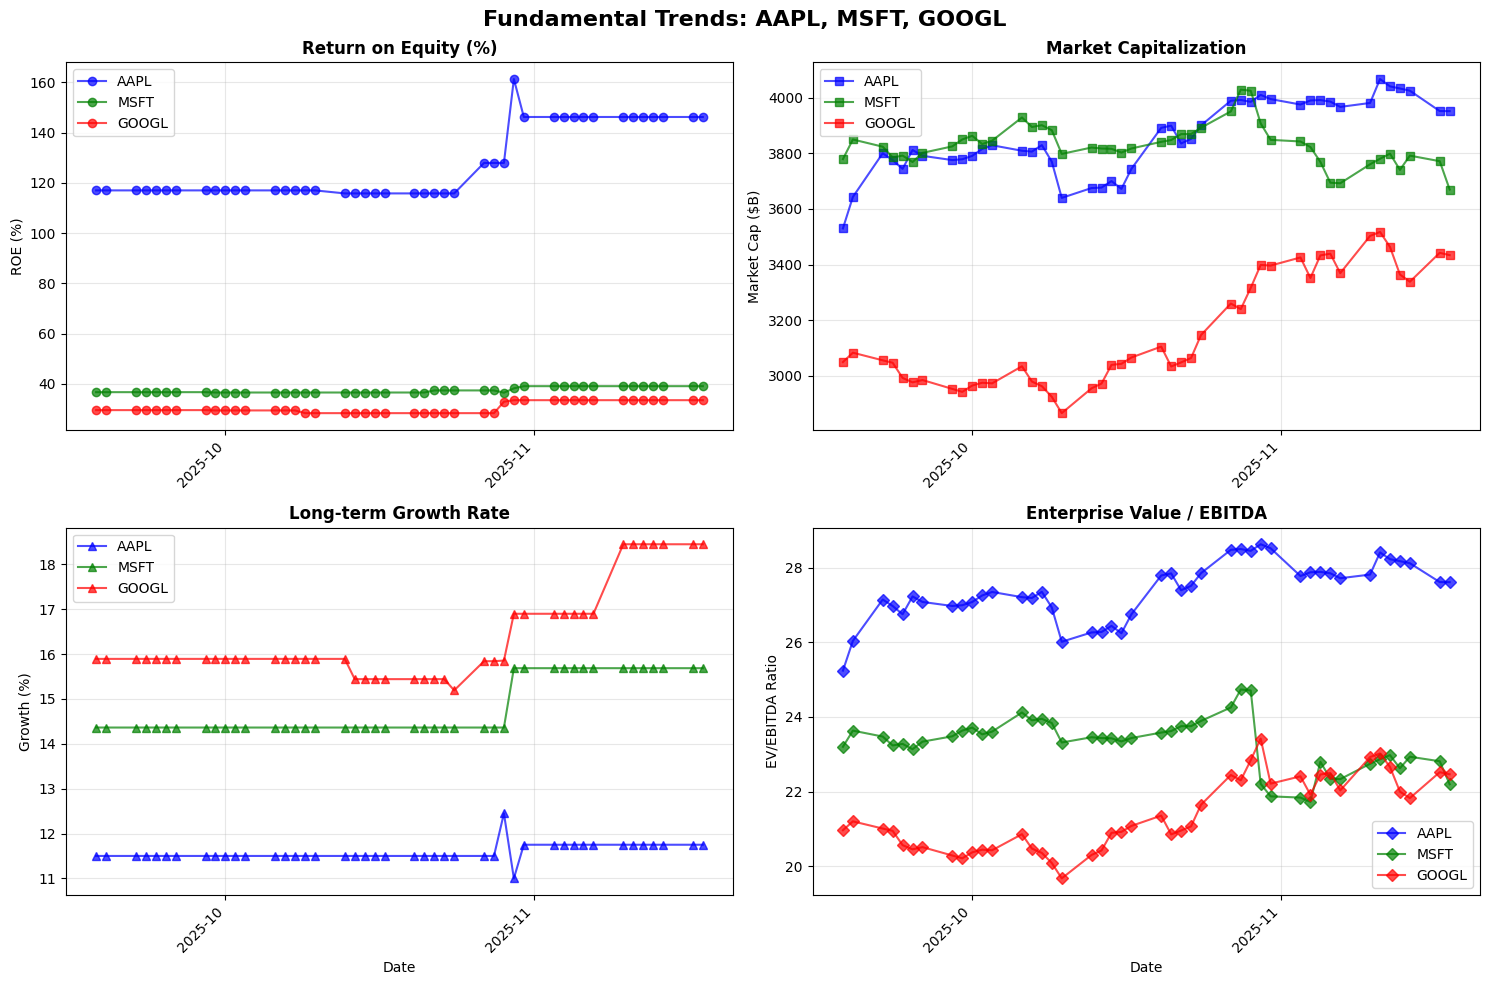

✓ Fundamental trends visualization complete


In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define symbols to track (re-define in case previous cell wasn't run)
symbols = ['AAPL', 'MSFT', 'GOOGL']
assets = [asset_finder.lookup_symbol(sym, as_of_date=None) for sym in symbols]

# Create pipeline if not already created in previous cell
if 'symbol_data' not in locals():
    print("Fetching time series data...")
    pipeline = Pipeline(
        columns={
            'ROE': CustomFundamentals.ReturnOnEquity_SmartEstimat.latest,
            'Market_Cap': CustomFundamentals.CompanyMarketCap.latest,
            'Price': CustomFundamentals.RefPriceClose.latest,
            'Growth': CustomFundamentals.LongTermGrowth_Mean.latest,
            'EV_EBITDA': CustomFundamentals.EnterpriseValueToEBITDA_DailyTimeSeriesRatio_.latest,
        }
    )
    
    # Get valid trading sessions (last 3 months, timezone-naive at midnight)
    end_search = pd.Timestamp.now().normalize()
    start_search = (end_search - pd.DateOffset(months=3)).normalize()
    
    sessions = trading_calendar.sessions_in_range(start_search, end_search)
    end_date = sessions[-5]
    start_date = (end_date - pd.DateOffset(months=2)).normalize()
    start_date = trading_calendar.sessions_in_range(start_date, end_date)[0]
    
    result = engine.run_pipeline(pipeline, start_date, end_date)

# Normalize dataframe to fix pandas 2.x dtype issues
result = result.copy()
for col in result.columns:
    if result[col].dtype == object:
        try:
            result[col] = result[col].astype(float)
        except (ValueError, TypeError):
            pass
    symbol_data = result[result.index.get_level_values(1).isin(assets)]
    print(f"✓ Fetched {len(symbol_data):,} observations")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Fundamental Trends: AAPL, MSFT, GOOGL', fontsize=16, fontweight='bold')

# Prepare data for each symbol
symbol_colors = {'AAPL': 'blue', 'MSFT': 'green', 'GOOGL': 'red'}

for idx, (symbol, asset) in enumerate(zip(symbols, assets)):
    sym_data = symbol_data.loc[pd.IndexSlice[:, asset], :]
    sym_data = sym_data.reset_index(names=['date', 'asset'])
    
    color = symbol_colors[symbol]
    
    # Plot 1: ROE over time
    axes[0, 0].plot(sym_data['date'], sym_data['ROE'], 
                    label=symbol, marker='o', color=color, alpha=0.7)
    
    # Plot 2: Market Cap over time
    axes[0, 1].plot(sym_data['date'], sym_data['Market_Cap'] / 1e9, 
                    label=symbol, marker='s', color=color, alpha=0.7)
    
    # Plot 3: Growth Rate over time
    axes[1, 0].plot(sym_data['date'], sym_data['Growth'], 
                    label=symbol, marker='^', color=color, alpha=0.7)
    
    # Plot 4: EV/EBITDA over time
    axes[1, 1].plot(sym_data['date'], sym_data['EV_EBITDA'], 
                    label=symbol, marker='D', color=color, alpha=0.7)

# Customize subplots
axes[0, 0].set_title('Return on Equity (%)', fontweight='bold')
axes[0, 0].set_ylabel('ROE (%)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].set_title('Market Capitalization', fontweight='bold')
axes[0, 1].set_ylabel('Market Cap ($B)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].set_title('Long-term Growth Rate', fontweight='bold')
axes[1, 0].set_ylabel('Growth (%)')
axes[1, 0].set_xlabel('Date')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_title('Enterprise Value / EBITDA', fontweight='bold')
axes[1, 1].set_ylabel('EV/EBITDA Ratio')
axes[1, 1].set_xlabel('Date')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Format x-axis dates
for ax in axes.flat:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("✓ Fundamental trends visualization complete")

### Pipeline Examples Summary

You now know how to:
- ✅ Set up a Pipeline engine with custom fundamentals
- ✅ Query latest fundamentals for all stocks
- ✅ Filter stocks using fundamental criteria
- ✅ Extract time series data for specific symbols
- ✅ Visualize fundamental trends over time

**Key takeaways:**
- Use `CustomFundamentals.ColumnName.latest` to access any fundamental metric
- Combine multiple metrics with boolean operators (`&`, `|`) for screening
- Run pipelines over date ranges to analyze trends
- Filter results by asset to focus on specific symbols
- Integrate with matplotlib for visualization

**Next steps:**
- Use these patterns in your backtesting algorithms
- Create custom factors combining multiple fundamentals
- Integrate with price data from USEquityPricing
- Build sophisticated stock selection strategies

## 12. Running Backtests with Custom Fundamentals

### Using the Strategy File

I've created a working strategy file: **`strategy_top5_roe.py`**

This strategy:
- ✅ Uses your custom Custom fundamentals
- ✅ Filters to top 100 stocks by market cap
- ✅ Selects top 5 stocks by ROE
- ✅ Rebalances weekly (every Monday)
- ✅ Equal weights (20% each)

### How to Run

**From terminal/command line:**
```bash
cd /data/backtest_results
python strategy_top5_roe.py
```

**From Jupyter:**

In [17]:
# Run the strategy
import subprocess
import sys

result = subprocess.run(
    [sys.executable, 'strategy_top5_roe.py'],
    cwd='/app/examples/strategies',
    capture_output=True,
    text=True
)

print(result.stdout)
if result.stderr:
    print("STDERR:", result.stderr)

✓ sharadar bundle registered

BUILDING PIPELINE LOADERS
✓ Pipeline loader map built (12 columns mapped)
  - Pricing columns: 5
  - Fundamental columns: 7 (auto-discovered)

BACKTEST CONFIGURATION
Strategy: Top 5 ROE from Top 100 by Market Cap
Period: 2021-01-01 to 2025-11-15 (5.0 years)
Capital: $100,000
Rebalancing: Weekly
Bundle: sharadar
Database: /data/custom_databases/fundamentals.sqlite
Progress updates: Every 1 days
Pipeline logging: Disabled
Rebalance logging: Minimal

ENABLING PROGRESS LOGGING
✓ Progress logging enabled
  Algorithm: Top5-ROE-Strategy
  Update interval: 1 days

RUNNING BACKTEST
Start time: 2025-11-24 06:59:03

⚠ Yahoo Finance bundles not available: No module named 'zipline.data.bundles.yahoo_bundle'
⚠ NASDAQ Data Link bundles not available: No module named 'zipline.data.bundles.nasdaq_bundle'
✓ Sharadar bundles registered

Available bundles:
  - yahoo, yahoo-tech, yahoo-dow, yahoo-sp500
  - nasdaq, nasdaq-premium, nasdaq-free, nasdaq-sp500
  - sharadar, sharada

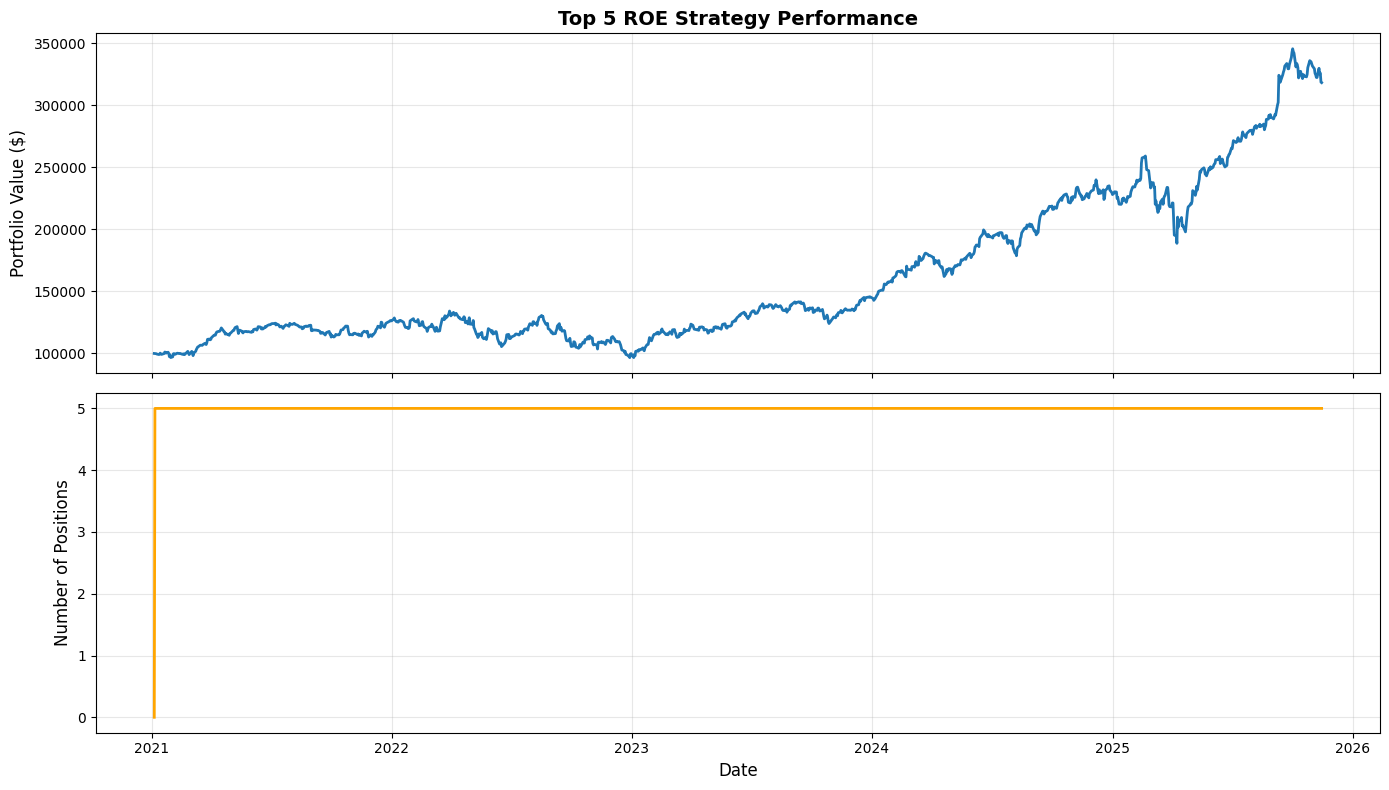


Performance Summary:
  Final Value: $318,093.17
  Total Return: 218.09%
  Avg Positions: 5.0


In [18]:
import os

import pandas as pd
import matplotlib.pyplot as plt

# Load saved results
if not os.path.exists("/data/backtest_results/backtest_results.pkl"):
    print("⚠️  Backtest results not found at /data/backtest_results/backtest_results.pkl")
    print("Please run the backtest in the previous cell first.")
else:
    results = pd.read_pickle('/data/backtest_results/backtest_results.pkl')

    # Plot results
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Portfolio value
    axes[0].plot(results.index, results['portfolio_value'], linewidth=2)
    axes[0].set_ylabel('Portfolio Value ($)', fontsize=12)
    axes[0].set_title('Top 5 ROE Strategy Performance', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Number of positions
    axes[1].plot(results.index, results['num_positions'], linewidth=2, color='orange')
    axes[1].set_ylabel('Number of Positions', fontsize=12)
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nPerformance Summary:")
    print(f"  Final Value: ${results.portfolio_value.iloc[-1]:,.2f}")
    print(f"  Total Return: {(results.portfolio_value.iloc[-1]/100000-1)*100:.2f}%")
    print(f"  Avg Positions: {results.num_positions.mean():.1f}")

/usr/local/lib/python3.11/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '26.902%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2021-01-04
End date,2025-11-14
Total months,58
,Backtest
Annual return,26.902%
Cumulative returns,218.093%
Annual volatility,21.737%
Sharpe ratio,1.20
Calmar ratio,0.96
Stability,0.80
Max drawdown,-27.976%


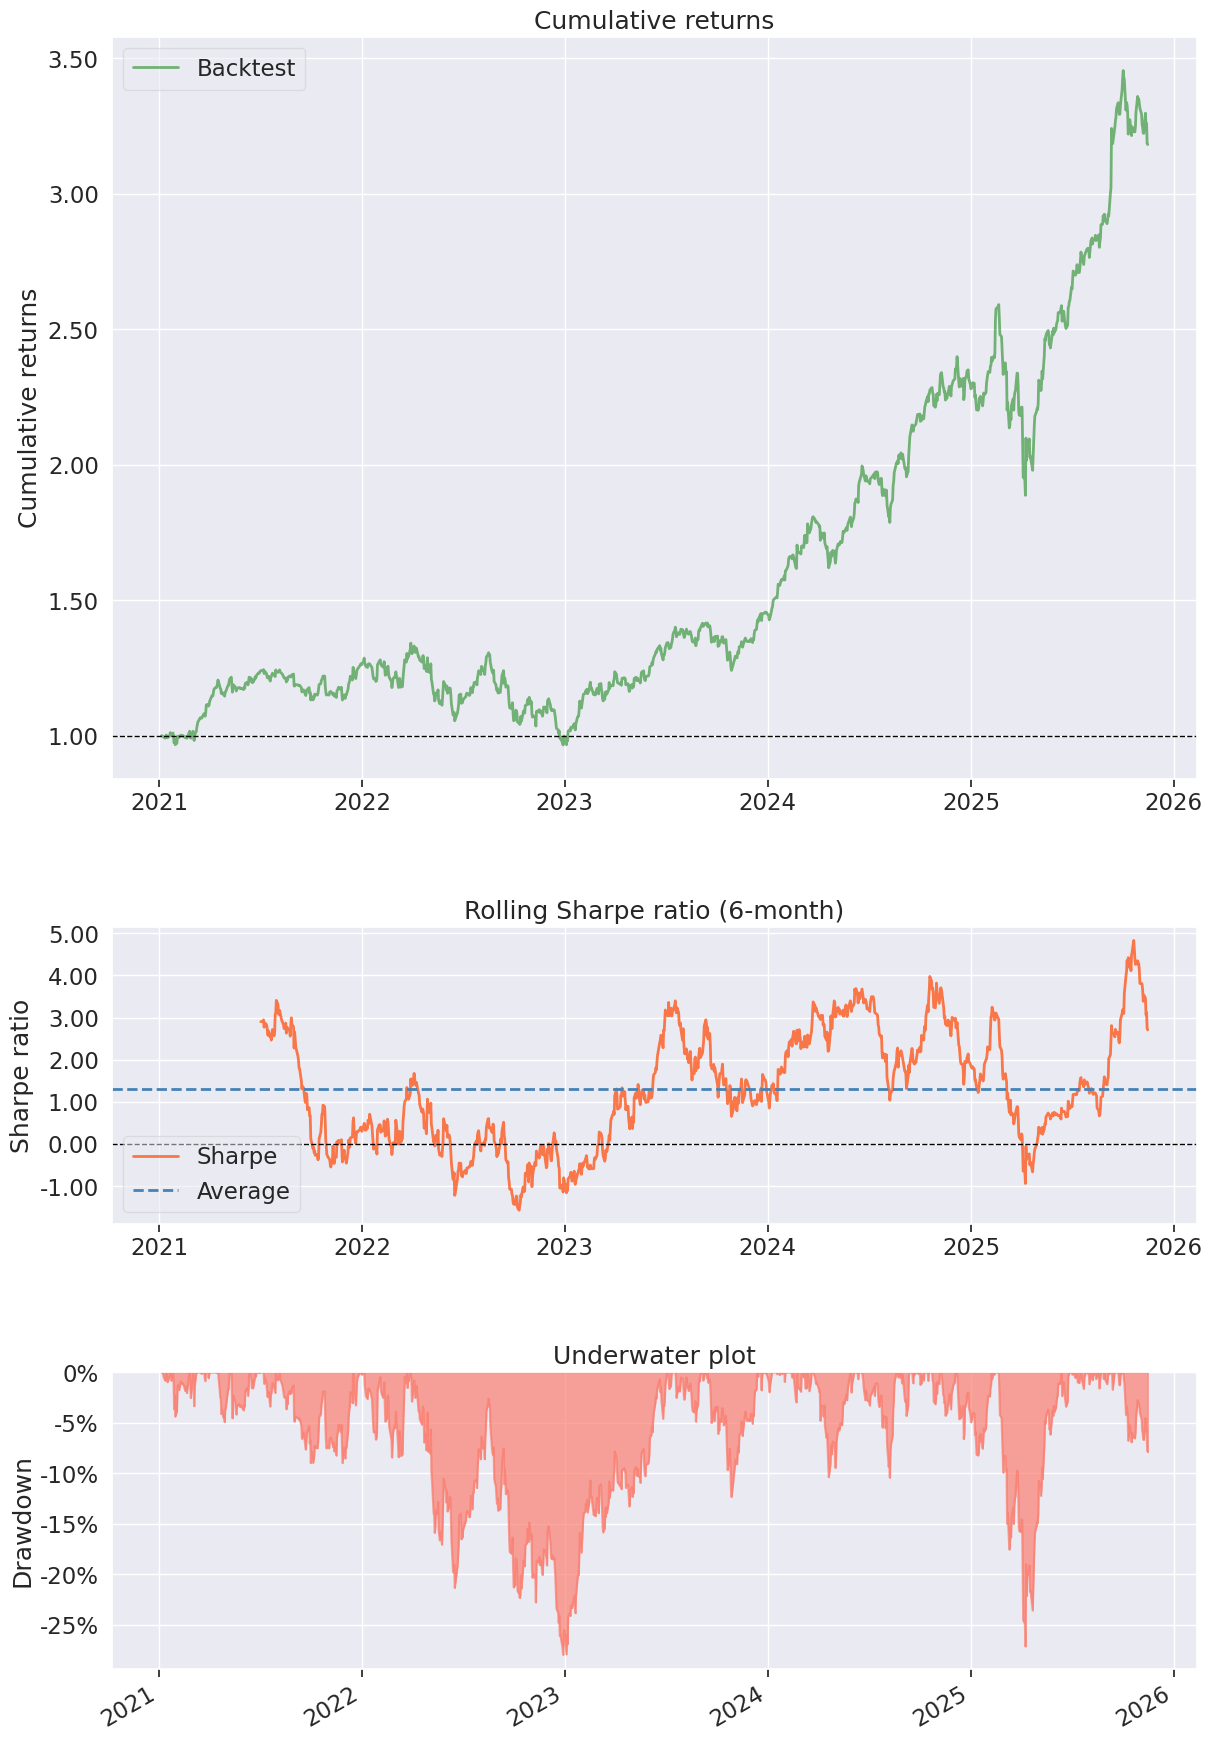

In [19]:
# Analyze with pyfolio
import pyfolio as pf

returns = results.returns
pf.create_simple_tear_sheet(returns)

### Customizing the Strategy

Edit `strategy_top5_roe.py` to:

**Change selection criteria:**
```python
# Select top 10 instead of top 5
top_10_roe = roe.top(10, mask=top_100_by_mcap)

# Use different fundamentals
roa = CustomFundamentals.ReturnOnAssets_SmartEstimate.latest
growth = CustomFundamentals.LongTermGrowth_Mean.latest

# Combine multiple factors
roe_z = roe.zscore(mask=top_100_by_mcap)
growth_z = growth.zscore(mask=top_100_by_mcap)
combined = (roe_z + growth_z) / 2
top_stocks = combined.top(5, mask=top_100_by_mcap)
```

**Change rebalancing frequency:**
```python
# Monthly rebalancing
schedule_function(
    rebalance,
    date_rules.month_start(),
    time_rules.market_open(hours=1),
)

# Daily rebalancing
schedule_function(
    rebalance,
    date_rules.every_day(),
    time_rules.market_open(hours=1),
)
```

**Change date range:**
```python
start = pd.Timestamp('2023-01-01', tz='UTC')
end = pd.Timestamp('2024-12-31', tz='UTC')
```